# ランダムフォレスト

**データの準備**

学習に使うデータをロードします。

In [1]:
import pandas as pd
from sklearn import model_selection

# positive, neutral, negative の中から negative なレビューを当てるタスクとして、
# negativeを1に、それ以外のpositive, neutralを0に設定します。
data = pd.read_csv("input/pn_same_judge.csv")
data["label_num"] = data["label"].map({"positive": 0, "neutral": 0, "negative": 1})
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

特徴量を作るためにトークナイザを定義します。

In [2]:
import spacy

nlp = spacy.load("ja_core_news_md")

def tokenize(text):
   return [token.lemma_ for token in nlp(text)]

2022-05-25 02:12:05.262010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-25 02:12:05.262136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import PrecisionRecallDisplay

## 決定木

ランダムフォレストは決定木の
[バギング](https://ja.wikipedia.org/wiki/バギング)
によりアンサンブル学習する手法なので、
まずは決定木から始めましょう。

決定木を学習するには
[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
を使います。
ここでは正則化のために `max_depth`, `min_samples_leaf` パラメータを指定しています。

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
pipe_dt = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, random_state=0)),
])

In [68]:
pipe_dt.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f6b35f53820>)),
                ('clf',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=10,
                                        random_state=0))])

In [69]:
score_dt = pipe_dt.predict_proba(test["text"])[:,1]

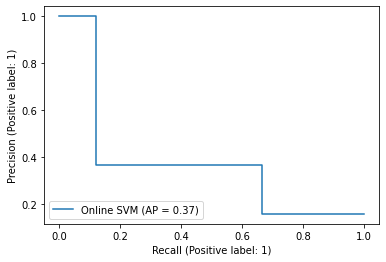

In [70]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_dt,
    name="Decision Tree",
)

木を表示してみましょう。

```{note}
sklearn 0.21 から
[plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree)
で決定木を表示できるようになりました。

以下のドキュメントが参考になります。

* [https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html)
* [https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)
```

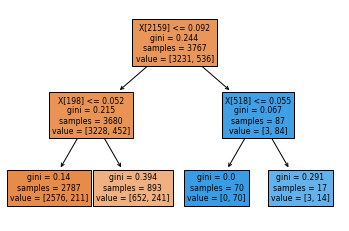

In [71]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plot_tree(pipe_dt["clf"], filled=True)
plt.show()

In [72]:
words = pipe_dt["vect"].get_feature_names_out()

In [73]:
words[2159], words[198], words[518]

('残念', 'が', 'ます')

## ランダムフォレスト

ランダムフォレストは決定木をバギングしたモデルです。
`sklearn.ensemble.BaggingClassifier` を使うと次のように実装できます。

In [75]:
from sklearn.ensemble import BaggingClassifier

In [118]:
bagging = BaggingClassifier(
    DecisionTreeClassifier(splitter="random"),  # splitterはrandomに設定して、特徴量をランダムに探索する
    n_estimators=1000,
    random_state=0,
    n_jobs=-1,  # 全てのCPUを使う
)
pipe_bagging = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", bagging),
])

In [119]:
pipe_bagging.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f6b35f53820>)),
                ('clf',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(splitter='random'),
                                   n_estimators=1000, n_jobs=-1,
                                   random_state=0))])

In [120]:
score_bagging = pipe_bagging.predict_proba(test["text"])[:,1]

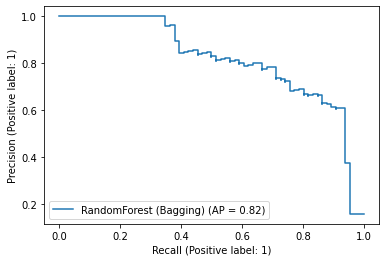

In [121]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_bagging,
    name="RandomForest (Bagging)",
)

BuggingClassifier を使って実装しなくても、scikit-learn は
[sklearn.ensembleRandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
を提供しています。
ランダムフォレストを使う場合は、こちらを使う方がいいでしょう。

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
random_forest = RandomForestClassifier(
    n_estimators=1000,
    random_state=0,
    n_jobs=-1,
)
pipe_rf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", random_forest),
])

In [137]:
pipe_rf.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f6b35f53820>)),
                ('clf',
                 RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                        random_state=0))])

In [138]:
score_rf = pipe_rf.predict_proba(test["text"])[:,1]

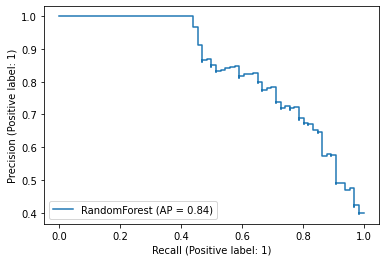

In [139]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_rf,
    name="RandomForest",
)

## 特徴量の重要度

ランダムフォレストでは、 `feature_importances_` 属性を見ることで、 素性の重要度を知ることができます。
モデルの精度を改善していくステップで重要な情報となります。

In [140]:
pipe_rf["clf"].feature_importances_

array([1.65558859e-03, 3.07076053e-06, 1.61683381e-04, ...,
       1.16837655e-04, 3.25194851e-05, 1.91331985e-04])

In [141]:
importances = pipe_rf["clf"].feature_importances_

In [142]:
list(sorted(zip(importances, words), reverse=True))[:10]

[(0.06326427694429575, '残念'),
 (0.03175729495181406, 'が'),
 (0.029402603271193865, '狭い'),
 (0.025630317721141334, 'ない'),
 (0.02421808005918753, '。'),
 (0.020671870849808417, '少し'),
 (0.020182005782368, 'ぬ'),
 (0.01855193604701994, 'た'),
 (0.01610895740164117, 'です'),
 (0.015484141988555758, '悪い')]

この結果を見ると、「が」「です」といった分類に効果があるとは思えない単語が重要な素性として選ばれてしまっていることが分かります。
そこで、例えば次の手としてストップワードを定義して素性から取り除く方針が思いつきます。

このように、素性を選択するためにランダムフォレストをまずは適用してみるという方針も可能です。

## 勾配ブースティング

最後に、勾配ブースティングの手法を見ておきます。

勾配ブースティングを分類問題に適用するには
[sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
を使います。

並列化できず、したがって `n_jobs` パラメータは指定できないことに注意してください。



In [128]:
from sklearn.ensemble import GradientBoostingClassifier

In [151]:
gb = GradientBoostingClassifier(
    n_estimators=1000,
    random_state=0,
    learning_rate=0.1,
)

pipe_gb = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", gb),
])

In [152]:
pipe_gb.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f6b35f53820>)),
                ('clf',
                 GradientBoostingClassifier(n_estimators=1000,
                                            random_state=0))])

In [153]:
score_gb = pipe_gb.predict_proba(test["text"])[:,1]

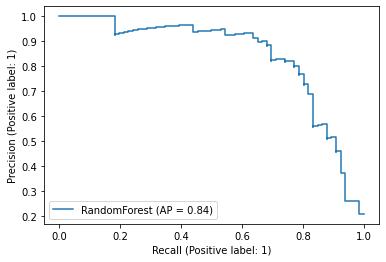

In [154]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_gb,
    name="RandomForest",
)

```{note}
正則化としてearly stoppingを使う場合には `n_iter_no_change` と `validation_fraction` を設定します。

    gb = GradientBoostingClassifier(
        n_estimators=1000,
        random_state=0,
        learning_rate=0.1,
        # early stoppingのための設定
        validation_fraction=0.1,
        n_iter_no_change=3,
    )

```